# Advanced Lane Line Detection Project

This project is part of the Self Driving Car Engineer Nanodegree Programm of Udacity

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import pickle
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
os.listdir("camera_cal/")

In [ ]:
cal_image_paths = ["camera_cal/"+file for file in os.listdir("camera_cal/") if file.endswith(".jpg")]
cal_images = [mpimg.imread(cal_image_path) for cal_image_path in cal_image_paths]

In [ ]:
for cal_image in cal_images:
    print(cal_image.shape)

In [ ]:
plt.imshow(cal_images[0])

In [ ]:
def grayscale_conversion(images):
    grays = []
    for image in images:
        grays.append(cv2.cvtColor(image, cv2.COLOR_RGB2GRAY))
    return grays

In [ ]:
def get_object_image_points(grays, nx, ny,):
    
    objpoints = []
    imgpoints = []

    objp = np.zeros((nx*ny, 3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)
    
    for gray in grays:
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        # If found, draw corners
        if ret == True:
            # Draw and display the corners
            imgpoints.append(corners)
            objpoints.append(objp)
    return objpoints, imgpoints

In [ ]:
def create_calibration_coef(images, nx, ny):
    grays = grayscale_conversion(images)
    objpoints, imgpoints = get_object_image_points(images, nx, ny)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, grays[0].shape[::-1], None, None)
    data = {
    'ret': ret,
    'mtx': mtx,
    'dist': dist,
    'rvecs': rvecs,
    'tvecs': tvecs        
    }

    with open('camera_cal/calibration_data.p', 'wb') as f:
        # Pickle the 'data' dictionary using the highest protocol available.
        pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)
    f.close()
    return ret, mtx, dist, rvecs, tvecs

In [ ]:
ret, mtx, dist, rvecs, tvecs = create_calibration_coef(cal_images, 9, 6)

In [ ]:
def undistor_images(images, path_names):
    
    if os.path.exists('camera_cal/calibration_data.p'):
        with open('camera_cal/calibration_data.p', 'rb') as f:
            cal_data = pickle.load(f)
            f.close()
        mtx = cal_data["mtx"]
        dist = cal_data["dist"]
    else:
        ret, mtx, dist, rvecs, tvecs = create_calibration_coef(images, 9, 6)
    for img, path_name in zip(images, path_names):
        file_name = path_name.split(".")[0]
        file_type = path_name.split(".")[1]
        undist = cv2.undistort(img, mtx, dist, None, mtx)
        mpimg.imsave(file_name+"_undist."+file_type, undist)
        

In [ ]:
undistor_images(cal_images, cal_image_paths)

In [ ]:
def print_images(images, grayscale = False):
    '''This is a helper function to print multiple images in one plot. 
    Grayscale images are shown with the boolean `grayscale` input '''
    no_channels = len(images)
    no_images = len(images[0])
    if no_channels > 1:
        f, axarr = plt.subplots(no_images, no_channels, figsize = (15, 30))
        for i,channel in enumerate(images):
            for k, image in enumerate(channel):
                axarr[k][i].imshow(image, cmap = 'gray' if grayscale[i] else 'brg')
    else:
        f, axarr = plt.subplots(no_images, 1, figsize = (15, 30))
        for i, image in enumerate(images[0]):
            axarr[i].imshow(image, cmap = 'gray' if grayscale else 'brg')

In [2]:
folder = "test_images/"
test_image_paths = [folder+image for image in os.listdir(folder)]
test_images = [mpimg.imread(test_image_path) for test_image_path in test_image_paths]

In [ ]:
print_images([test_images])

In [3]:
def load_calibration_data():
    if os.path.exists('camera_cal/calibration_data.p'):
        with open('camera_cal/calibration_data.p', 'rb') as f:
            cal_data = pickle.load(f)
            f.close()
        return cal_data

In [ ]:
image = test_images[0]

In [4]:
camera_calibration = load_calibration_data()

In [ ]:
undist = cv2.undistort(image, camera_calibration['mtx'], camera_calibration['dist'], None, camera_calibration['mtx'])

In [ ]:
print_images([[image, undist]])

In [5]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, mag_thresh=(0, 255)):
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    sobel = cv2.Sobel(gray, cv2.CV_64F, int(orient == 'x'), int(orient == 'y'), ksize=sobel_kernel)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    binary_output = np.copy(sbinary) # Remove this line
    return binary_output

In [6]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    sobely = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    sobel_dir = np.arctan2(sobely, sobelx)
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(sobel_dir)
    binary_output[(sobel_dir >= thresh[0]) & (sobel_dir <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

In [7]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    sobelxy = np.sqrt(np.square(sobelx) + np.square(sobely))
    # 3) Calculate the magnitude 
    scaled_sobel = np.uint8(255*sobelxy/np.max(sobelxy))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    return binary_output

In [8]:
def s_abs_thresh(img, s_thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    #scaled = np.uint8(255*s_channel/np.max(s_channel))
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    return s_binary

In [9]:
def l_sobel_thresh(img, orient='x', sobel_kernel=3, l_thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    # Sobel x
    sobel = cv2.Sobel(l_channel, cv2.CV_64F, int(orient == 'x'), int(orient == 'y'), ksize=sobel_kernel) # Take the derivative in x
    abs_sobel = np.absolute(sobel) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= l_thresh[0]) & (scaled_sobel <= l_thresh[1])] = 1
    return sxbinary

In [10]:
def rgb_thresh(img, c_thresh, space = None):
    if space.capitalize() == "R":
        gray = img[:,:,0]
    elif space.capitalize() == "G":
        gray = img[:,:,1]
    elif space.capitalize() == "B":
        gray = img[:,:,2]
    else:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    #scaled = np.uint8(255*gray/np.max(gray))
    c_binary = np.zeros_like(gray)
    c_binary[(gray > c_thresh[0]) & (gray < c_thresh[1])]=1
    return c_binary

In [11]:
def get_binary_warped_debug(image, camera_calibration, transforamtion_matrix, source_pts, tar_pts):    
    
    if image[0,0,0].dtype == 'float32':
        image = np.uint8(255*image)
    
    copy = np.copy(image)
    #step1 apply undistorting
    
    undist = cv2.undistort(copy, camera_calibration['mtx'], camera_calibration['dist'], None, camera_calibration['mtx'])
    #step2: find gradients in x direction in RGB space
    #undist = np.uint8(255*undist/np.max(undist))
    imshape = undist.shape
    #parallelogram_src = np.array(source_pts, dtype=np.int32)
    #parallelogram_src = parallelogram_src.reshape((-1, 1, 2)) 
    #undist_line = cv2.polylines(np.copy(undist), [parallelogram_src], True, (0, 0, 255), 3)
    # e) use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(undist, transforamtion_matrix, (undist.shape[1], undist.shape[0]), flags=cv2.INTER_LINEAR)
    #parallelogram_tar = np.array(tar_pts, dtype=np.int32)
    #parallelogram_tar = parallelogram_tar.reshape((-1, 1, 2)) 
    #warped_line = cv2.polylines(np.copy(warped), [parallelogram_tar], True, (0, 0, 255), 3)
    x_thresh = (20,80)
        
    x_binary = abs_sobel_thresh(warped, orient = "x", sobel_kernel = 15, mag_thresh=x_thresh)
    #step4 find gradients in x direction in lightning channel
    l_thresh = (20, 80)
    l_binary = l_sobel_thresh(warped, orient="x", sobel_kernel=7, l_thresh=l_thresh)
    
    s_thresh = (40, 90)
    s_binary = s_abs_thresh(warped, s_thresh=s_thresh)
    
    color_thresh = (160,254)
    color_binary = rgb_thresh(warped, c_thresh = color_thresh, space = "R")
    combined = np.zeros_like(s_binary)
    combined[(x_binary==1)&((s_binary==1) | ((color_binary==1)&(l_binary ==1)))] = 1
    #|  & ((s_binary==1)| (color_binary==1))| (s_binary==1)| (color_binary==1) | (l_binary ==1)(l_binary ==1)
    
    
    return undist, warped, x_binary, l_binary, s_binary, color_binary, combined

In [12]:
def get_binary_warped(image, camera_calibration, transforamtion_matrix, source_pts, tar_pts):    
    
    if image[0,0,0].dtype == 'float32':
        image = np.uint8(255*image)
    
    copy = np.copy(image)
    #step1 apply undistorting
    
    undist = cv2.undistort(copy, camera_calibration['mtx'], camera_calibration['dist'], None, camera_calibration['mtx'])
    #step2: find gradients in x direction in RGB space
    #undist = np.uint8(255*undist/np.max(undist))
    imshape = undist.shape
    #parallelogram_src = np.array(source_pts, dtype=np.int32)
    #parallelogram_src = parallelogram_src.reshape((-1, 1, 2)) 
    #undist_line = cv2.polylines(np.copy(undist), [parallelogram_src], True, (0, 0, 255), 3)
    # e) use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(undist, transforamtion_matrix, (undist.shape[1], undist.shape[0]), flags=cv2.INTER_LINEAR)
    #parallelogram_tar = np.array(tar_pts, dtype=np.int32)
    #parallelogram_tar = parallelogram_tar.reshape((-1, 1, 2)) 
    #warped_line = cv2.polylines(np.copy(warped), [parallelogram_tar], True, (0, 0, 255), 3)
    x_thresh = (20,80)
        
    x_binary = abs_sobel_thresh(warped, orient = "x", sobel_kernel = 15, mag_thresh=x_thresh)
    #step4 find gradients in x direction in lightning channel
    l_thresh = (20, 80)
    l_binary = l_sobel_thresh(warped, orient="x", sobel_kernel=7, l_thresh=l_thresh)
    
    s_thresh = (40, 90)
    s_binary = s_abs_thresh(warped, s_thresh=s_thresh)
    
    color_thresh = (160,254)
    color_binary = rgb_thresh(warped, c_thresh = color_thresh, space = "R")
    combined = np.zeros_like(s_binary)
    combined[(x_binary==1)&((s_binary==1) | ((color_binary==1)&(l_binary ==1)))] = 1
    #|  & ((s_binary==1)| (color_binary==1))| (s_binary==1)| (color_binary==1) | (l_binary ==1)(l_binary ==1)
    
    
    return undist, warped, combined

In [13]:
image = test_images[5]
y_ofs = 0
src = np.float32([[(190,image.shape[0]),(575, 460), (710, 460), (1150,image.shape[0])]])        

            # b) define 4 source points src = np.float32([[,],[,],[,],[,]])
                 #Note: you could pick any four of the detected corners 
                 # as long as those four corners define a rectangle
                 #One especially smart way to do this would be to use four well-chosen
                 # corners that were automatically detected during the undistortion steps
                 #We recommend using the automatic detection of corners in your code
            # c) define 4 destination points dst = np.float32([[,],[,],[,],[,]])
x_ofs = 320
dst = np.float32([[x_ofs,image.shape[0]], [x_ofs,0],[image.shape[1] - x_ofs,0], [image.shape[1] - x_ofs,image.shape[0]]])
            # d) use cv2.getPerspectiveTransform() to get M, the transform matrix
M = cv2.getPerspectiveTransform(src, dst)
            
        
undist, warped, x_binary, l_binary, s_binary, color_binary, result = get_binary_warped_debug(image, camera_calibration, M, src, dst)

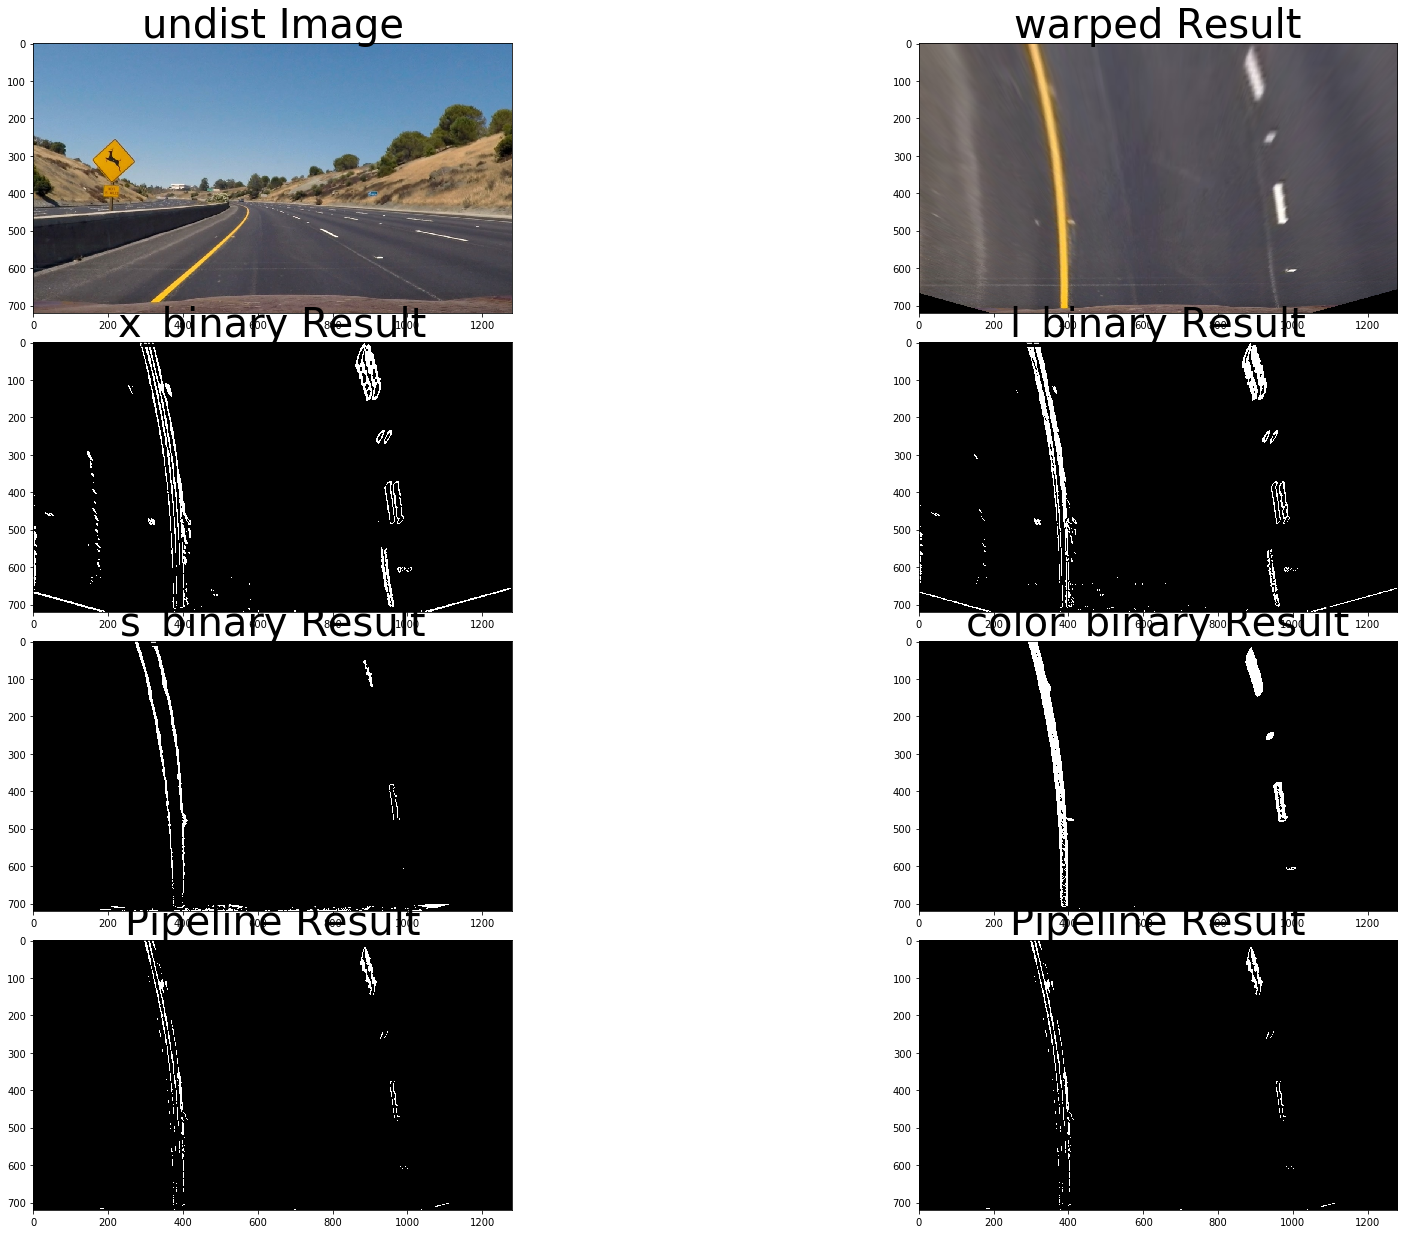

In [14]:
#%matplotlib qt
%matplotlib inline
f, (ax1) = plt.subplots(4, 2, figsize=(24, 18))
f.tight_layout()

ax1[0][0].imshow(undist)
ax1[0][0].set_title('undist Image', fontsize=40)

ax1[0][1].imshow(warped, cmap='gray')
ax1[0][1].set_title('warped Result', fontsize=40)

ax1[1][0].imshow(x_binary, cmap='gray')
ax1[1][0].set_title('x_binary Result', fontsize=40)

ax1[1][1].imshow(l_binary, cmap='gray')
ax1[1][1].set_title('l_binary Result', fontsize=40)

ax1[2][0].imshow(s_binary, cmap='gray')
ax1[2][0].set_title('s_binary Result', fontsize=40)

ax1[2][1].imshow(color_binary, cmap='gray')
ax1[2][1].set_title('color_binary Result', fontsize=40)

ax1[3][0].imshow(result, cmap='gray')
ax1[3][0].set_title('Pipeline Result', fontsize=40)

ax1[3][1].imshow(result, cmap='gray')
ax1[3][1].set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [15]:
histogram = np.sum(result[result.shape[0]//2:,:], axis=0)

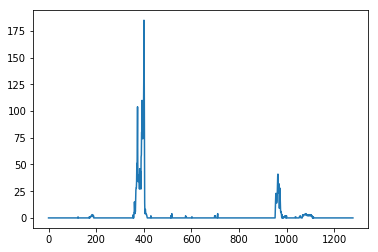

In [16]:
plt.plot(histogram)

In [17]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self, side = "l"):
        # was the line detected in the last iteration?
        self.side = side
        
        self.detected = False
        self.ploty = None
        self.recent_fit = []
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        self.filter_n = 20
        
        self.ym_per_pix = 30/720 # meters per pixel in y dimension
        self.xm_per_pix = 3.7/700
        
    def get_line (self, binary_warped):
        limit_diff = 0.5
        if self.detected == False:
            self.allx, self.ally = self.find_lane_pixels(binary_warped)
        else:
            self.allx, self.ally = self.search_around_poly(binary_warped)
        self.fit_poly(binary_warped.shape)
        #out_img = self.colorize_pixels(binary_warped)
        if self.detected:
            self.measure_curvature()
            self.measure_line_base_pos(binary_warped)
        
    def find_lane_pixels(self, binary_warped):
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]//2)
        if self.side == "l":
            x_base = np.argmax(histogram[:midpoint])
        elif self.side == "r":
            x_base = np.argmax(histogram[midpoint:]) + midpoint

        # HYPERPARAMETERS
        # Choose the number of sliding windows
        nwindows = 9
        # Set the width of the windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 50

        # Set height of windows - based on nwindows above and image shape
        window_height = np.int(binary_warped.shape[0]//nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated later for each window in nwindows
        x_current = x_base

        # Create empty lists to receive left and right lane pixel indices
        lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            ### TO-DO: Find the four below boundaries of the window ###
            win_x_low = x_current - margin  
            win_x_high = x_current + margin

            ### TO-DO: Identify the nonzero pixels in x and y within the window ###
            good_lane_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_x_low) &  (nonzerox < win_x_high)).nonzero()[0]

            # Append these indices to the lists
            lane_inds.append(good_lane_inds)


            ### TO-DO: If you found > minpix pixels, recenter next window ###
            ### (`right` or `leftx_current`) on their mean position ###
            if len(good_lane_inds) > minpix:
                #print(histogram)
                x_current = np.int(np.mean(nonzerox[good_lane_inds]))
                


        # Concatenate the arrays of indices (previously was a list of lists of pixels)
        try:
            lane_inds = np.concatenate(lane_inds)
        except ValueError:
            # Avoids an error if the above is not implemented fully
            pass

        # Extract left and right line pixel positions
        allx = nonzerox[lane_inds]
        ally = nonzeroy[lane_inds]

        return allx, ally
    def search_around_poly(self, binary_warped):
        # HYPERPARAMETER
        # Choose the width of the margin around the previous polynomial to search
        # The quiz grader expects 100 here, but feel free to tune on your own!
        margin = 100

        # Grab activated pixels
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        ### TO-DO: Set the area of search based on activated x-values ###
        ### within the +/- margin of our polynomial function ###
        ### Hint: consider the window areas for the similarly named variables ###
        ### in the previous quiz, but change the windows to our new search area ###
        fitx_tmp = self.best_fit[0]*nonzeroy**2 + self.best_fit[1]*nonzeroy + self.best_fit[2]
        lane_inds = ((nonzerox >= (fitx_tmp - margin)) &
        (nonzerox < (fitx_tmp + margin))).nonzero()[0]
        
        # Again, extract left and right line pixel positions
        allx = nonzerox[lane_inds]
        ally = nonzeroy[lane_inds]

        ## Visualization ##
        # Create an image to draw on and an image to show the selection window
        
        return allx,ally
    def colorize_pixels(self, binary_warped):
               
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        # Color in left and right line pixels
        if self.side == "l":
            out_img[self.ally, self.allx] = [255, 0, 0]
        else:
            out_img[self.ally, self.allx] = [0, 0, 255]
        return out_img
    def fit_poly(self, img_shape):
        ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
        limit_diff = np.array([0.5, 0.5, 1000])
        try:
            new_fit = np.polyfit(self.ally, self.allx, 2)
            self.diffs = new_fit - self.current_fit
            if np.any(np.abs(self.diffs) < limit_diff):
                self.detected = True
                self.current_fit = new_fit
                # Generate x and y values for plotting
                self.ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
                new_xfit = self.current_fit[0]*self.ploty**2 + self.current_fit[1]*self.ploty + self.current_fit[2]
                filter_n_iter(new_xfit)
            else:
                self.detected = False
        except:
            try:
                new_fit = np.polyfit(self.ally, self.allx, 2)
                self.diffs = new_fit - self.current_fit
                if np.any(np.abs(self.diffs) < limit_diff):
                    self.detected = True
                    self.current_fit = new_fit
                    # Generate x and y values for plotting
                    self.ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
                    new_xfit = self.current_fit[0]*self.ploty**2 + self.current_fit[1]*self.ploty + self.current_fit[2]
                    self.filter_n_iter(new_xfit)
                else:
                    self.detected = False
            except:
                self.detected = False
    def filter_n_iter(self, new_xfit):
        if len(self.recent_xfitted) < self.filter_n:
            self.recent_xfitted.append(new_xfit)
            self.recent_fit.append(self.current_fit)
        else:
            self.recent_xfitted = self.recent_xfitted[1:self.filter_n]
            self.recent_fit = self.recent_fit[1:self.filter_n]
            self.recent_xfitted.append(new_xfit)
            self.recent_fit.append(self.current_fit)
        self.bestx = np.mean(self.recent_xfitted, axis = 0)
        self.best_fit = np.mean(self.recent_fit, axis = 0)
    def measure_curvature(self):
        '''
        Calculates the curvature of polynomial functions in meters.
        '''
         # meters per pixel in x dimension   
        # Define y-value where we want radius of curvature
        # We'll choose the maximum y-value, corresponding to the bottom of the image
        fit_cr = np.polyfit(self.ploty*self.ym_per_pix, self.bestx*self.xm_per_pix, 2)
        y_eval = np.max(self.ploty)

        ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
        new_rad = ((1+np.square(2*self.best_fit[0]*y_eval*self.ym_per_pix+self.best_fit[1]))**(3/2))/(np.abs(2*self.best_fit[0]))  ## Implement the calculation of the left line here
        if self.radius_of_curvature == None:
            self.radius_of_curvature = new_rad
        else:
            self.radius_of_curvature = self.radius_of_curvature + (new_rad - self.radius_of_curvature)/self.filter_n
    def measure_line_base_pos(self, binary_warped):
        ideal_center = binary_warped.shape[1]//2
        new_pos = (self.current_fit[0]*binary_warped.shape[0]**2 + self.current_fit[1]*binary_warped.shape[0] + self.current_fit[2] - ideal_center)*self.xm_per_pix
        if self.line_base_pos == None:
            self.line_base_pos = new_pos
        else:
            self.line_base_pos = self.line_base_pos + (new_pos - self.line_base_pos)/self.filter_n

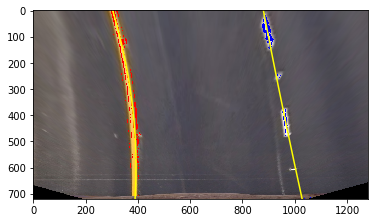

In [18]:
left_line = Line()
warped_ll =left_line.get_line(result)

right_line = Line('r')
warped_rl = right_line.get_line(result)
out_img = np.copy(warped)
out_img[left_line.ally, left_line.allx] = [255, 0, 0]
out_img[right_line.ally, right_line.allx] = [0, 0, 255]

# Plots the left and right polynomials on the lane lines
plt.plot(left_line.bestx, left_line.ploty, color='yellow')
plt.plot(right_line.bestx, right_line.ploty, color='yellow')
plt.imshow(out_img)

In [19]:
right_line.detected

True

2451.0741652753904
left:  -1.351779960286262 right:  1.6586075084382552


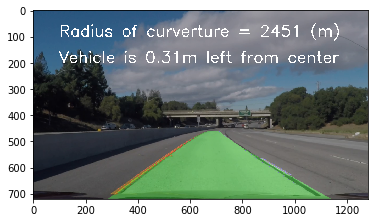

In [20]:
# Create an image to draw the lines on
%matplotlib qt
#%matplotlib inline
image = test_images[0]
undist, warped, result = get_binary_warped(image, camera_calibration, M, src, dst)
left_line = Line()
warped_ll =left_line.get_line(result)

right_line = Line('r')
warped_rl = right_line.get_line(result)

warp_zero = np.zeros_like(result).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_line.bestx, left_line.ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_line.bestx, right_line.ploty])))])
pts = np.hstack((pts_right, pts_left))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
color_warp[left_line.ally, left_line.allx] = [255,0, 0]
color_warp[right_line.ally, right_line.allx] = [0,0, 255]
Minv = np.linalg.inv(M)
# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(undist, 0.75, newwarp, 0.3, 0)
curverture = 0.5*(left_line.radius_of_curvature + right_line.radius_of_curvature)
away_from_center = right_line.line_base_pos + left_line.line_base_pos
if away_from_center > 0:
    side = "left"
else:
    side = "right"
print(curverture)
print("left: ", left_line.line_base_pos, "right: ", right_line.line_base_pos)
cv2.putText(result, "Radius of curverture = {:.0f} (m)".format(curverture), org = (100,100), fontFace = cv2.FONT_HERSHEY_SIMPLEX, fontScale = 2, color = (255,255,255), thickness = 3)
cv2.putText(result, "Vehicle is {:.2f}m {} from center".format(np.abs(away_from_center), side), org = (100,200), fontFace = cv2.FONT_HERSHEY_SIMPLEX, fontScale = 2, color = (255,255,255), thickness = 3)
plt.imshow(result)

In [21]:
def process_image(image):
    
    src = np.float32([[(190,image.shape[0]),(575, 460), (710, 460), (1150,image.shape[0])]])        
    x_ofs = 320
    dst = np.float32([[x_ofs,image.shape[0]], [x_ofs,0],[image.shape[1] - x_ofs,0], [image.shape[1] - x_ofs,image.shape[0]]])
                # d) use cv2.getPerspectiveTransform() to get M, the transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    camera_calibration = load_calibration_data()
    undist, warped, result = get_binary_warped(image, camera_calibration, M, src, dst)
    
    warped_ll =left_line.get_line(result)

    
    warped_rl = right_line.get_line(result)

    warp_zero = np.zeros_like(result).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_line.bestx, left_line.ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_line.bestx, right_line.ploty])))])
    pts = np.hstack((pts_right, pts_left))

    # Draw the lane onto the warped blank image
    if np.any(pts == None):
        pts = src
    
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    color_warp[left_line.ally, left_line.allx] = [255,0, 0]
    color_warp[right_line.ally, right_line.allx] = [0,0, 255]
    Minv = np.linalg.inv(M)
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 0.75, newwarp, 0.3, 0)
    curverture = 0.5*(left_line.radius_of_curvature + right_line.radius_of_curvature)
    away_from_center = right_line.line_base_pos + left_line.line_base_pos
    if away_from_center > 0:
        side = "left"
    else:
        side = "right"
    cv2.putText(result, "Radius of curverture = {:.0f} (m)".format(curverture), org = (100,100), fontFace = cv2.FONT_HERSHEY_SIMPLEX, fontScale = 2, color = (255,255,255), thickness = 3)
    cv2.putText(result, "Vehicle is {:.2f}m {} from center".format(np.abs(away_from_center), side), org = (100,200), fontFace = cv2.FONT_HERSHEY_SIMPLEX, fontScale = 2, color = (255,255,255), thickness = 3)
    return result
    

In [22]:
new_path = "output_images/"
for img, path_name in zip(test_images, test_image_paths):
        file_path_name = path_name.split(".")[0]
        file_name = file_path_name.split("/")[1]
        file_type = path_name.split(".")[1]
        left_line = Line()
        right_line = Line('r')
        out_img = process_image(img)
        mpimg.imsave(new_path+file_name+"_processed."+file_type, out_img)

In [23]:
left_line = Line()
right_line = Line('r')

white_output = 'output_videos/challenge_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Moviepy - Building video output_videos/challenge_video.mp4.
Moviepy - Writing video output_videos/challenge_video.mp4



Moviepy - Done !
Moviepy - video ready output_videos/challenge_video.mp4
Wall time: 1min 42s


In [24]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [25]:
left_line = Line()
right_line = Line('r')

white_output = 'output_videos/harder_challenge_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("harder_challenge_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Moviepy - Building video output_videos/harder_challenge_video.mp4.
Moviepy - Writing video output_videos/harder_challenge_video.mp4



Moviepy - Done !
Moviepy - video ready output_videos/harder_challenge_video.mp4
Wall time: 3min 57s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [27]:
left_line = Line()
right_line = Line('r')

white_output = 'output_videos/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Moviepy - Building video output_videos/project_video.mp4.
Moviepy - Writing video output_videos/project_video.mp4



Moviepy - Done !
Moviepy - video ready output_videos/project_video.mp4
Wall time: 3min 57s


In [28]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))